In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook as tqdm

import pymc3

plt.rcParams['font.size'] = 14

import visa
nirm = visa.ResourceManager()
oscp = nirm.open_resource("TCPIP::192.168.14.41::inst0::INSTR")
print(oscp.query('*IDN?'))
fgen = nirm.open_resource("TCPIP::192.168.14.42::inst0::INSTR")
print(fgen.query('*IDN?'))

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


RIGOL TECHNOLOGIES,DS2202,DS2A151700862,00.03.03.SP1

Rigol Technologies,DG4202,DG4E153900825,00.01.07



## RC Low Pass Filter Configuration

Use R = 10k, C = 10nF

In [2]:
R = 10e3
C = 10e-9
fc = 1/(2*np.pi*R*C)
print(fc)

1591.5494309189535


Set Initial Signal Generator Settings

2 Vpp, 100Hz

In [3]:
fgen.write(':SOURCE1:VOLTAGE:AMPLITUDE 2.0')
fgen.write(':SOURCE1:FREQ 100')
fgen.write(':OUTP1:STAT ON')

oscp.write(':TIMEBASE:MAIN:SCALE 0.005')
oscp.write(':CHAN1:SCALE 0.5')
oscp.write(':CHAN2:SCALE 0.5')

(18, <StatusCode.success: 0>)

Measure Oscilloscope Output

In [4]:
Vin = float(oscp.ask(':MEAS:VAMP? CHAN1'))
Vout = float(oscp.ask(':MEAS:VAMP? CHAN2'))
print(Vin, Vout)

2.057 2.013


Now we need to step through the measurements! One possible issue: do we need to autoscale the oscilloscope?

In [5]:
fgen.write(':SOURCE1:FREQ 10000')
time.sleep(0.5)
Vin = float(oscp.ask(':MEAS:VAMP? CHAN1'))
Vout = float(oscp.ask(':MEAS:VAMP? CHAN2'))
print(Vin, Vout)

2.14 0.42


Looks like we're good on time scaling, at least up to 10 kHz! Note that there needs to be a delay to allow the signal generator to settle. 0.1s is not enough--even at 0.5s, I'm seeing glitches in the data. I'm using 1.0s here. 

Additionally, I probably need to auto-scale the y-axis on the oscilloscope to get a better measurement.

Now we set up the loop.

In [7]:
Vin = []
Vout = []
Freq = np.arange(100,20001,100)
f1 = []
f2 = []

Vscales = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
c1_scale = 0
c2_scale = 0

for f in tqdm(Freq):
    fgen.write(':SOURCE1:FREQ {0}'.format(f))
    time.sleep(1.0)
    Vin.append(float(oscp.ask(':MEAS:VAMP? CHAN1')))
    while Vin[-1]<Vscales[c1_scale]:
        c1_scale+=1
        oscp.write(':CHAN1:SCALE {0}'.format(Vscales[c1_scale]))
        time.sleep(1.0)
        Vin[-1] = float(oscp.ask(':MEAS:VAMP? CHAN1'))
        
    Vout.append(float(oscp.ask(':MEAS:VAMP? CHAN2')))
    while Vout[-1]<Vscales[c2_scale]:
        c2_scale+=1
        oscp.write(':CHAN2:SCALE {0}'.format(Vscales[c2_scale]))
        time.sleep(1.0)
        Vout[-1] = float(oscp.ask(':MEAS:VAMP? CHAN2'))
        
    f1.append(float(oscp.ask(':MEAS:FREQ? CHAN1')))
    f2.append(float(oscp.ask(':MEAS:FREQ? CHAN2')))

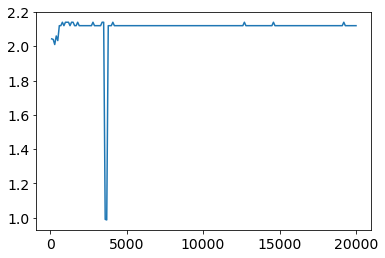

In [8]:
plt.plot(Freq,Vin)

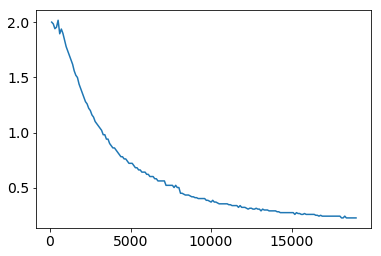

In [9]:
plt.plot(Freq[:-10],Vout[:-10])

Looks like there are still some issues! We need to do some averaging.

Frequency measurement is off when there are two many periods in the measurement range too, so add some auto-ranging for both V and T.

In [18]:
def getV(chan,N=10):
    V = np.array([float(oscp.ask(':MEAS:VAMP? CHAN{0}'.format(chan))) for s in range(N*4)])
    V.sort()
    return V[N:N*3].mean()
    
def getF(chan,N=10):
    F = np.array([float(oscp.ask(':MEAS:FREQ? CHAN{0}'.format(chan))) for s in range(N*4)])
    F.sort()
    return F[N:N*3].mean()

In [23]:
time.sleep(10)
Vin = []
Vout = []
Freq = np.arange(100,20001,100)
f1 = []
f2 = []

Vscales = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
c1_scale = 0
c2_scale = 0
Tscales = [2e-3, 1e-3, 5e-4, 2e-4, 1e-4, 5e-5]
t_scale = 0

oscp.write(':CHAN1:SCALE {0}'.format(Vscales[c1_scale]))
oscp.write(':CHAN2:SCALE {0}'.format(Vscales[c2_scale]))
oscp.write(':TIMEBASE:MAIN:SCALE {0}'.format(Tscales[t_scale]))

for f in tqdm(Freq):
    fgen.write(':SOURCE1:FREQ {0}'.format(f))
    if f*Tscales[t_scale]>1.5:
        t_scale += 1
        oscp.write(':TIMEBASE:MAIN:SCALE {0}'.format(Tscales[t_scale]))
    time.sleep(1.0)
    Vin.append(getV(1,10))
    while Vin[-1]<3*Vscales[c1_scale]:
        c1_scale+=1
        oscp.write(':CHAN1:SCALE {0}'.format(Vscales[c1_scale]))
        time.sleep(1.0)
        Vin[-1] = getV(1,10)
        
    Vout.append(getV(2,10))
    while Vout[-1]<3*Vscales[c2_scale]:
        c2_scale+=1
        oscp.write(':CHAN2:SCALE {0}'.format(Vscales[c2_scale]))
        time.sleep(1.0)
        Vout[-1] = getV(2,10)
        
    f1.append(getF(1,10))
    f2.append(getF(2,10))

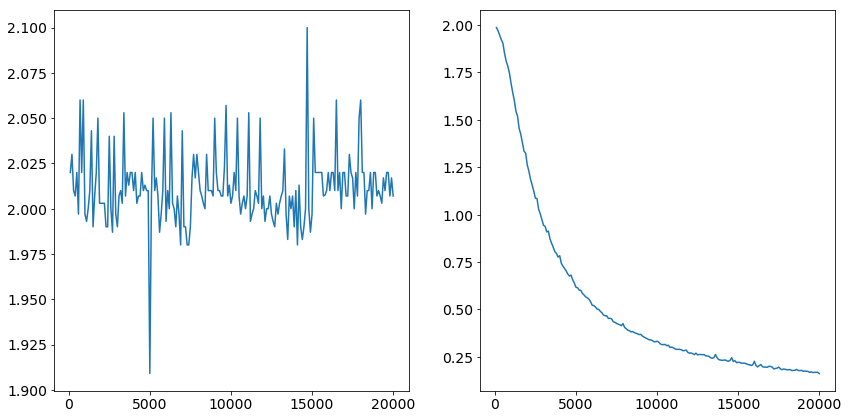

In [24]:
Vin = np.array(Vin)
Vout = np.array(Vout)
fig,ax = plt.subplots(1,2,figsize=(14,7))
ax[0].plot(Freq,Vin)
ax[1].plot(Freq,Vout)

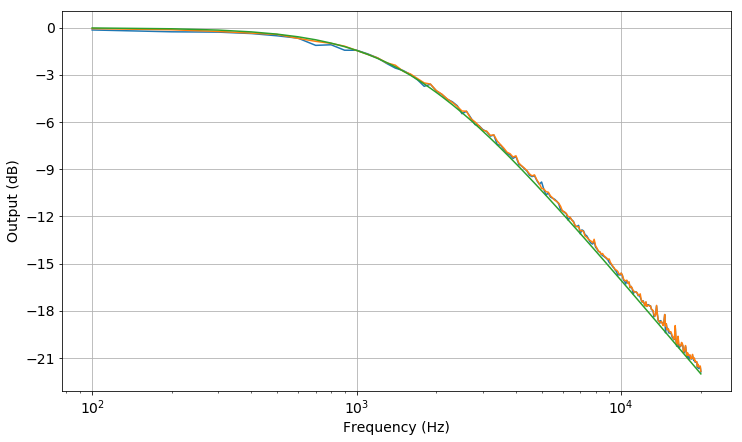

In [28]:
Xc = 1/(2*np.pi*Freq*C)
Predicted = Xc/np.sqrt(R**2+Xc**2)

fig,ax = plt.subplots(1,1,figsize=(12,7))
ax.semilogx(Freq,20*np.log10(Vout/Vin))
ax.plot(Freq,20*np.log10(Vout/2))
ax.plot(Freq,20*np.log10(Predicted))
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Output (dB)")
ax.set_yticks([0,-3,-6,-9,-12,-15,-18,-21])
ax.grid(True)
None

Alright, now we're getting somewhere! We just need to add some logic to increase the Voltage scales so that we can sweep both low- and high-pass filters, giving us the ability to scan the bandwidth of a full band-pass or notch filter.

In [22]:
8/2.5

3.2